In [24]:
from google.colab import files
src = list(files.upload().values())[0]
open('features_building.py','wb').write(src)
import features_building

Saving features_building.py to features_building (1).py


In [25]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from ta.momentum import *
from ta.volume import *
from ta.trend import *
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
from prettytable import PrettyTable
from sklearn.metrics import precision_recall_fscore_support
import joblib
from features_building import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import multiprocessing as mp
from pandas_datareader import data as web
import io

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:98% !important;}</style>"))

In [27]:
from google.colab import files
uploaded = files.upload()

Saving stock_indices.xlsx to stock_indices (1).xlsx


In [28]:
import pandas as pd
import io

df = pd.ExcelFile(io.BytesIO(uploaded['stock_indices.xlsx']))
SP500_data = pd.read_excel(df, 'S&P 500').set_index('Date')
Nasdaq_data = pd.read_excel(df, 'NASDAQ COMPOSITE').set_index('Date')
DJ_data = pd.read_excel(df, 'DOW JONES').set_index('Date')

In [29]:
def process_data(data):
    data.index = pd.to_datetime(data.index, format='%Y/%m/%d')
    data = data[['Open', 'Close', 'High', 'Low', 'Volume']]
    data = data.rename(columns={'Volume': 'Tick volume'})
    data = data.sort_values('Date', ascending=True)
    data['Change'] = data['Close'] - data['Close'].shift(1)
    data['Change'][data['Change'] <= 0] = 0
    data['Change'][data['Change'] > 0] = 1
    data['Down'] = -data['Change'] + 1
    data['Percent'] = 100 * (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    return data


SP500_data = process_data(SP500_data).drop('2011-12-30')
SP500_data = SP500_data[SP500_data['Percent'] != 0]
Nasdaq_data = process_data(Nasdaq_data).drop('2011-12-30')
Nasdaq_data = Nasdaq_data[Nasdaq_data['Percent'] != 0]
DJ_data = process_data(DJ_data).drop('2011-12-30')
DJ_data = DJ_data[DJ_data['Percent'] != 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning

In [30]:
uploaded = files.upload()

Saving textblob_polarity.csv to textblob_polarity.csv


In [31]:
news_data = pd.read_csv(io.BytesIO(uploaded['textblob_result.csv'])).set_index('Date')
news_data.index = pd.to_datetime(news_data.index)
news_data['Polarity'] = news_data['Polarity'].shift(1)
news_data = news_data.drop('2011-12-30')

In [32]:
news_data

,Polarity
Date,
2012-01-02,0.0
2012-01-03,1.0
2012-01-04,0.0
2012-01-05,0.0
2012-01-06,0.0
...,...
2022-02-24,0.0
2022-02-25,0.0
2022-02-26,0.0


In [33]:
def generate_feature(data, index):
    feature_choices = list(range(0, 100, 1))  #!
    try:
        remove_list = []  #!
        for i in remove_list:
            feature_choices.remove(i)
    except:
        feature_choices = feature_choices
    # feature_choices = [6]  #!
    feature_pool = []
    for feature_choice in feature_choices:
        if not isinstance(feature_building().cal_feature(data, feature_choice), pd.Series):
            continue
        feature_pool.append(feature_building().cal_feature(data, feature_choice).rename(index + '_' + str(feature_choice)))
    features = pd.concat(feature_pool, axis=1)
    features = (features - features.min()) / (features.max() - features.min())
    # features['Change11'] = data['Change'].shift(1)
    return features

In [34]:
def selection_kbest(features):
    fs = SelectKBest(f_classif, k=int(features.shape[1] * 0.9) + 1)
    features = fs.fit_transform(np.array(features), np.array(SP500_data.loc[start_date:end_date]['Change']))
    features = pd.DataFrame(features)
    print(features.shape)
    return features

def selection_corr(features):
    if len(features.iloc[0]) > 5:
        feature_corr = features.corr()
        corr_std = 0.8  #!
        columns = np.full((feature_corr.shape[0], ), True, dtype=bool)
        for i in range(feature_corr.shape[0]):
            for j in range(i + 1, feature_corr.shape[0]):
                if abs(feature_corr.iloc[i, j]) > corr_std:
                    columns[j] = False
        selected_columns = features.columns[columns]
        features = features[selected_columns]
    return features

def selection_pca(features):
    if len(features.iloc[0]) > 5 and variance_inflation_factor(features.iloc[50:].values, 1) > 5:
        pca = PCA(n_components='mle')
        features = pd.DataFrame(pca.fit_transform(features))
        features = (features - features.min()) / (features.max() - features.min())
        mask = np.triu(np.ones_like(features.corr(), dtype=bool))
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(features.corr(), cmap="RdBu_r", linewidth=0.3, mask=mask, vmax=1, vmin=-1)
        plt.show()
        plt.close()
    return features

In [35]:
def Stock_Price_RNN_Data_Processing(data, index_name, mem_his_days):
    
    index_feature = generate_feature(data, index_name).replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
    features = index_feature.dropna(how='all', axis=1).dropna(how='any', axis=0)
    start_date = '2012.01.02'
    end_date = '2022.02.28'
    start_date = datetime.datetime.strptime(start_date, '%Y.%m.%d')
    end_date = datetime.datetime.strptime(end_date, '%Y.%m.%d')
    features = features.loc[start_date:end_date]
    
    features = selection_corr(features)
    features = pd.concat([features, news_data['Polarity']], axis=1)
    features = pd.concat([features, data['Percent']], axis=1).dropna(how='any')
    
    X_data = features.drop(['Percent'], axis=1)
    y_data = features['Percent']
    
    ss = StandardScaler()
    X_sca_data = ss.fit_transform(X_data)

    deq = deque(maxlen=mem_his_days)

    X = []
    for i in X_sca_data:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    y = y_data.values[mem_his_days-1:]
    
    X = np.array(X)
    y = np.array(y)
    
    X_trainall, X_test, y_trainall, y_test = train_test_split(X,y,shuffle=False,test_size=0.3)

    X_train, X_valid, y_train, y_valid = train_test_split(X_trainall,y_trainall,shuffle=False,test_size=0.2)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features.index


In [36]:
the_mem_days = 5
the_rnn_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_RNN_Data_Processing(SP500_data, 'SP500', the_mem_days)
                      
model = Sequential()
model.add(SimpleRNN(the_units,input_shape=X_train.shape[1:],activation='tanh'))
model.add(Dropout(0.3))                
                
for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='tanh'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
11/11 [==============================] - 2s 33ms/step - loss: 1.0457 - mape: 888.2087 - val_loss: 0.8265 - val_mape: 349.4818
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7699 - mape: 795.7775 - val_loss: 0.6599 - val_mape: 202.4786
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7013 - mape: 756.3887 - val_loss: 0.5654 - val_mape: 200.1408
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5899 - mape: 710.8477 - val_loss: 0.4983 - val_mape: 234.4778
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5241 - mape: 597.7755 - val_loss: 0.4372 - val_mape: 238.8787
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.4698 - mape: 670.3737 - val_loss: 0.3918 - val_mape: 246.1825
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4295 - mape: 678.6447 - val_loss: 0.3528 - val_mape: 236.9971
Epoch 8/100
11/11 [=====================

{'MAE': 0.4096601745500484, 'R2': 0.5767381415717329, 'MAPE': 1.5060513728922558, 'MSE': 0.8650602998283093}


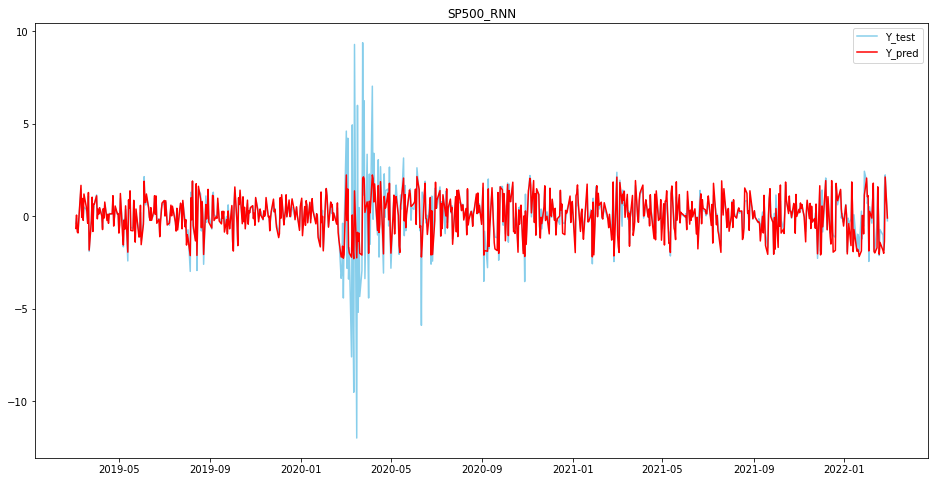

In [37]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('SP500' + '_' + 'RNN')
ax.legend()

plt.show()

In [38]:
the_mem_days = 5
the_rnn_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_RNN_Data_Processing(Nasdaq_data, 'Nasdaq', the_mem_days)
                      
model = Sequential()
model.add(SimpleRNN(the_units,input_shape=X_train.shape[1:],activation='tanh'))
model.add(Dropout(0.3))                
                
for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='tanh'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
11/11 [==============================] - 1s 29ms/step - loss: 1.3562 - mape: 608.5358 - val_loss: 1.2671 - val_mape: 1503.8976
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 1.0644 - mape: 472.6609 - val_loss: 1.0121 - val_mape: 1064.5565
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.8684 - mape: 424.5216 - val_loss: 0.8684 - val_mape: 771.3563
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7631 - mape: 444.3885 - val_loss: 0.7694 - val_mape: 610.4453
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6220 - mape: 342.7973 - val_loss: 0.6854 - val_mape: 608.4993
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6032 - mape: 359.2829 - val_loss: 0.6094 - val_mape: 659.1831
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5446 - mape: 435.8532 - val_loss: 0.5536 - val_mape: 481.9878
Epoch 8/100
11/11 [===================

{'MAE': 0.6768619370750341, 'R2': 0.5373228517760986, 'MAPE': 4.201679966634348, 'MSE': 1.175926077514297}


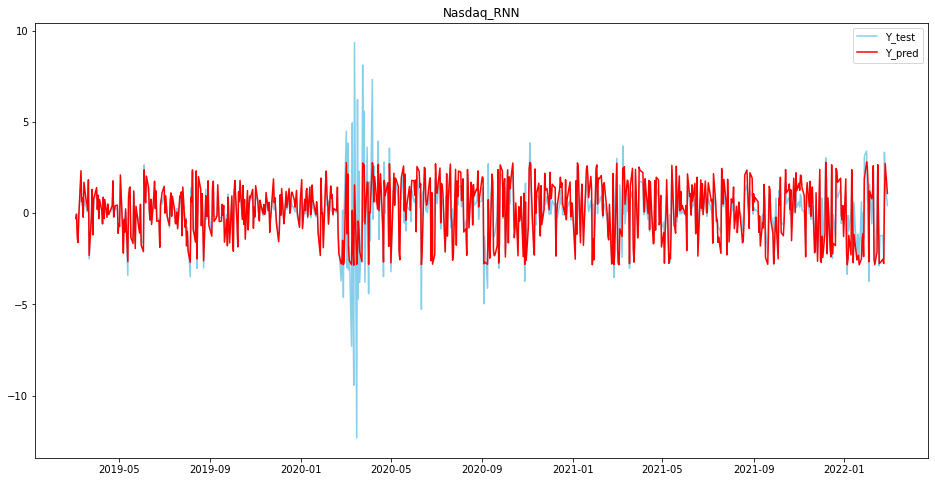

In [39]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('Nasdaq' + '_' + 'RNN')
ax.legend()

plt.show()

In [40]:
the_mem_days = 5
the_rnn_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_RNN_Data_Processing(DJ_data, 'DJ', the_mem_days)
                      
model = Sequential()
model.add(SimpleRNN(the_units,input_shape=X_train.shape[1:],activation='tanh'))
model.add(Dropout(0.3))                
                
for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='tanh'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
11/11 [==============================] - 1s 29ms/step - loss: 0.9909 - mape: 559.9113 - val_loss: 0.7856 - val_mape: 228.8871
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7329 - mape: 531.4739 - val_loss: 0.6440 - val_mape: 240.1214
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6778 - mape: 596.7767 - val_loss: 0.5611 - val_mape: 221.6541
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5866 - mape: 601.4794 - val_loss: 0.5012 - val_mape: 191.3129
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5239 - mape: 407.2873 - val_loss: 0.4491 - val_mape: 192.8562
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4429 - mape: 476.1560 - val_loss: 0.4078 - val_mape: 201.9177
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.4166 - mape: 459.9936 - val_loss: 0.3720 - val_mape: 192.9252
Epoch 8/100
11/11 [=====================

{'MAE': 0.4116034002649557, 'R2': 0.5341777075922548, 'MAPE': 4.631429973369255, 'MSE': 1.0258337816868652}


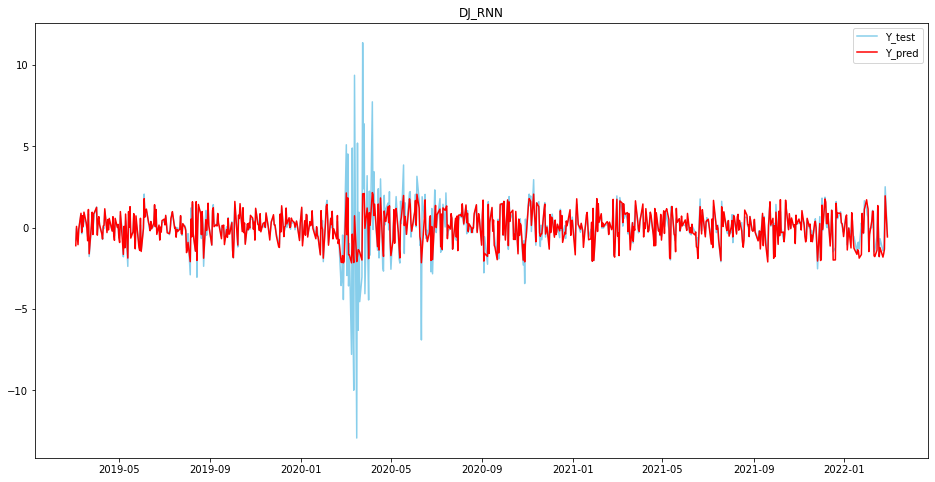

In [41]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('DJ' + '_' + 'RNN')
ax.legend()

plt.show()